# Homework 1

CS 637, Spring 2022

Due 3/3/21

1) Implement an API to create a fully-connected multilayer perceptron (MLP) for a *k*-class classification problem.

2) Test this implementation on MNIST data.

Notation

*  `w`: weights
*  `b`: biases
*  `z`: aggregated values
*  `a`: activated values
*  `x`: input to a neural network
*  `yhat`: output from a neural network (i.e., *after* softmax if applied). Equivalent to the activation from the output layer.

In [1]:
# Import basic Python dependencies
import numpy as np
import gzip
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9, 6) # Set size of plots in notebook

# 1. API

In [2]:
# Install the created API
#%pip install -e mlp_api

In [3]:
import site
site.main()
from mlp_api import *

# 2. Testing the API

## 2.1 Import the MNIST dataset
*   Downloaded the four files from http://yann.lecun.com/exdb/mnist/ and placed them in the subfolder mnist/ relative to this notebook.
*   Used `gzip` to read the files, then numpy to merge them again since splitting must be done my API.
*   Image ubyte files are offset by 16; labels by 8.


In [4]:
def read_mnist_gz(file, img_size=28, labels=False):
    f = gzip.open(file,'r')
    if labels:
        f.read(8)
        buffer = f.read()
        return np.frombuffer(buffer, dtype=np.uint8)
    else:
        f.read(16)
        buffer = f.read()
        return np.frombuffer(buffer, dtype=np.uint8).reshape(-1, img_size, img_size)

train_X = read_mnist_gz('mnist/train-images-idx3-ubyte.gz')
train_y = read_mnist_gz('mnist/train-labels-idx1-ubyte.gz', labels=True)
test_X = read_mnist_gz('mnist/t10k-images-idx3-ubyte.gz')
test_y = read_mnist_gz('mnist/t10k-labels-idx1-ubyte.gz', labels=True)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [5]:
mnist_all_X = np.concatenate((train_X, test_X), axis=0)
mnist_all_y = np.concatenate((train_y, test_y), axis=0)
print('MNIST features reshaped:', mnist_all_X.shape, 
      '\nMNIST labels reshaped:', mnist_all_y.shape)

MNIST features reshaped: (70000, 28, 28) 
MNIST labels reshaped: (70000,)


## 2.2 Preprocessing

Feature and label shapes: (784, 70000) (10, 70000)


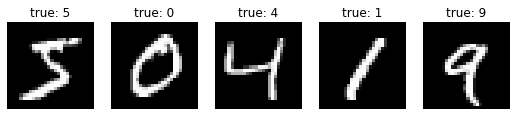

In [6]:
# Make a Dataset object
mnist_set = Dataset(mnist_all_X, mnist_all_y)

# Reshape the data
width = 28
categories = 10
mnist_set.shape(width, categories)
print("Feature and label shapes:", mnist_set.X.shape, mnist_set.y.shape)

# Visualize the first five images
Utility.plot_images(mnist_set, 5)

Splits on training, validation, & testing: (784, 49000) (784, 10500) (784, 10500)


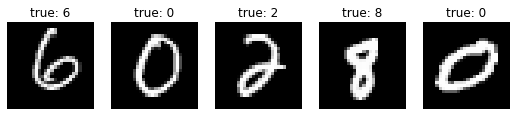

In [7]:
# Shuffle the data
mnist_set.shuffle()
Utility.plot_images(mnist_set, 5)

# Divide the data
mnist_set.divide()
print('Splits on training, validation, & testing:', 
      mnist_set.X_train.shape, mnist_set.X_valid.shape, mnist_set.X_test.shape)

## 2.3 Trying different models

### 2.3.1 Varying the learning rate

In [9]:
# Hyperparameters to use throughout all models
batch = 100
epochs = 15

In [9]:
dims = (width*width, 128, 64, 10)
activ_fns = (Activation.relu, Activation.relu, Activation.softmax)

# Make a generic neural network with two hidden layers
p_128_64 = Perceptron(dims, activ_fns, Loss.cross_entropy)

# Different learning rates to test
lr_train = {}
lr_valid = {}
lrs = (1e-4, 5e-4, 0.001, 0.005, 0.01)
for lr in lrs:
  p_128_64.reset() # Reinitialize parameters
  lr_train[lr] = Utility.train_epochs(p_128_64, mnist_set, lr, 
    epochs, batch, verbose=False)
  
  # At end of each model's training, validate
  valid_gen = mnist_set.make_batches(batch, 'valid')
  lr_valid[lr] = p_128_64.pass_data(valid_gen, lr, batch, train_mode=False)

Epoch 	Train_loss 	Train_acc
0 	    5.393 	    0.099
1 	    4.352 	    0.126
2 	    3.640 	    0.162


KeyboardInterrupt: 

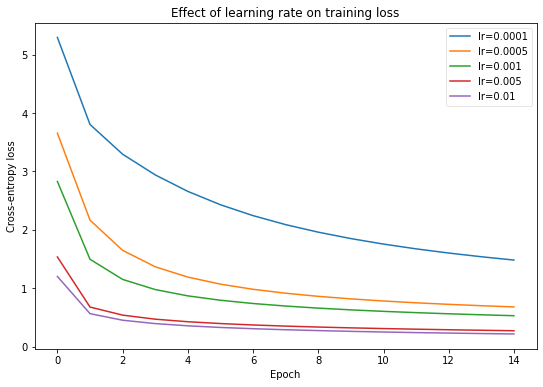

In [ ]:
# Plot training loss for the different learning rates used
Utility.plot_results([lr_train[_][0] for _ in lrs],
                     labels=['lr=' + str(lr) for lr in lrs],
                     ylabel='Cross-entropy loss',
                     title='Effect of learning rate on training loss')

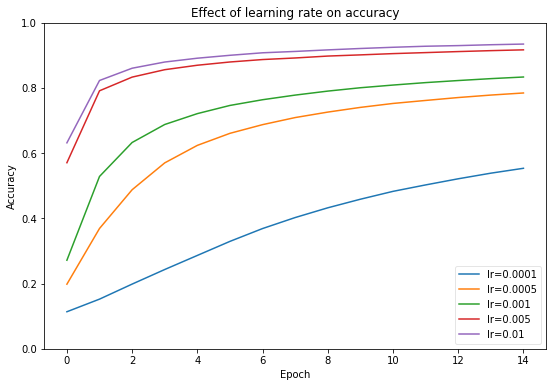

In [ ]:
# Plot training accuracy for the different learning rates used
Utility.plot_results([lr_train[_][1] for _ in lrs],
                     labels=['lr=' + str(lr) for lr in lrs],
                     ylabel='Accuracy',
                     title='Effect of learning rate on training accuracy')

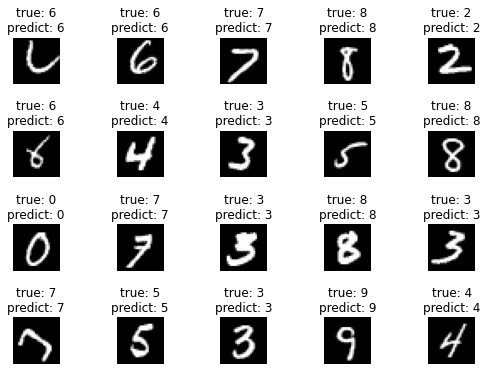

In [ ]:
# As an aside, visualize images from a random sample passed through the trained model
Utility.plot_images(mnist_set, 20, True, p_128_64)

In [18]:
# Validating: lr vs. loss
plt.plot(lrs, [lr_train[_][0][-1] for _ in lrs], '--', label='Training loss')
plt.plot(lrs, [lr_valid[_][0] for _ in lrs], 'o', label='Validation loss')
plt.plot(lrs, [lr_train[_][1][-1] for _ in lrs], '--', label='Training accuracy')
plt.plot(lrs, [lr_valid[_][1] for _ in lrs], 'o', label='Validation accuracy')
plt.title('Model selection')
plt.xlabel('Learning rate')
plt.ylabel('Cross-entropy loss')
plt.legend()

NameError: name 'lrs' is not defined

Based on the validation results, using a learning rate of 0.01 performed best (lowest loss and highest accuracy) when the architecture and number of epochs is held constant. As the last model used a learning rate of 0.01 is still in memory, pass the test data forwards through it to report the final performance.

In [ ]:
# Generate batches from test data, pass through model
test_gen = mnist_set.make_batches(batch, 'test')
loss, acc = p_128_64.pass_data(test_gen, train_mode=False) 
print('Cross-entropy loss: {:.3f}\nAccuracy: {:.1f}%'.format(loss, acc*100))

Cross-entropy loss: 0.238
Accuracy: 93.1%


### 2.3.2 Varying the architecture

*   Number of hidden layers
*   Number of neurons per layer



In [89]:
# Define different architectures to try
lr_fixed = 0.001
arch_train = {}
arch_valid = {}
dims_set = ((width*width, 64, 32, 10),
            (width*width, 256, 128, 10),
            (width*width, 128, 64, 32, 10),
            (width*width, 256, 128, 64, 10))
activ_fns_set = ((Activation.relu, Activation.relu, Activation.softmax),
                 (Activation.relu, Activation.relu, Activation.softmax),
                 (Activation.relu, Activation.relu, Activation.relu, Activation.softmax),
                 (Activation.relu, Activation.relu, Activation.relu, Activation.softmax))

# Train models
for dims, activ_fns in zip(dims_set, activ_fns_set):
  p = Perceptron(dims, activ_fns, Loss.cross_entropy)
  arch_train[dims] = Utility.train_epochs(p, mnist_set, lr_fixed, 
    epochs, batch, verbose=False)

  # After training a model, validate
  valid_gen = mnist_set.make_batches(batch, 'valid')
  arch_valid[dims] = p.pass_data(valid_gen, lr_fixed, batch, train_mode=False)

Epoch 	Train_loss 	Train_acc
0 	    1.101 	    0.646
1 	    0.550 	    0.827
2 	    0.438 	    0.864
3 	    0.382 	    0.883
4 	    0.345 	    0.895
5 	    0.319 	    0.903
6 	    0.298 	    0.909
7 	    0.280 	    0.916
8 	    0.267 	    0.921
9 	    0.254 	    0.924
10 	    0.243 	    0.928
11 	    0.233 	    0.930
12 	    0.224 	    0.933
13 	    0.217 	    0.935
14 	    0.209 	    0.937
Time elapsed (s): 24.9

Epoch 	Train_loss 	Train_acc


c:\users\rrbdelldesktop3\documents\school\cs_637\hw1\mlp_api\mlp_api\loss.py:34: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(-y / yhat, axis=0).reshape(-1, 1).T
c:\users\rrbdelldesktop3\documents\school\cs_637\hw1\mlp_api\mlp_api\loss.py:34: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(-y / yhat, axis=0).reshape(-1, 1).T


0 	      nan 	    0.297


Exception: Loss has become NaN or infinity! Stop training.

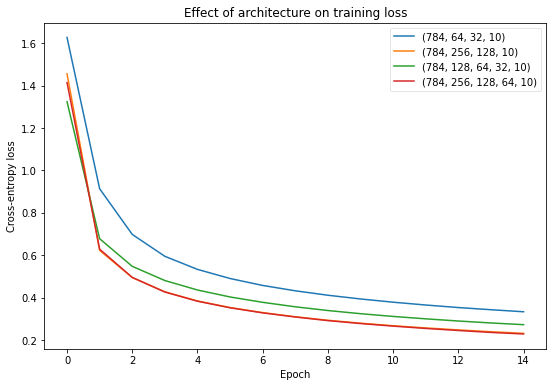

In [67]:
# Plot loss for the different architectures tried
Utility.plot_results([arch_train[_][0] for _ in dims_set],
                     labels=[str(dims) for dims in dims_set],
                     ylabel='Cross-entropy loss',
                     title='Effect of architecture on training loss')

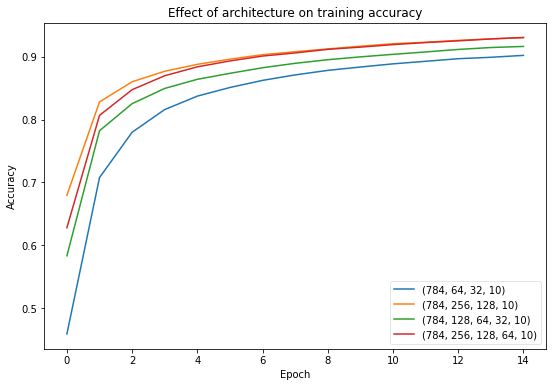

In [69]:
# Plot accuracy for different architectures tried
Utility.plot_results([arch_train[_][1] for _ in dims_set],
                     labels=[str(dims) for dims in dims_set],
                     ylabel='Accuracy',
                     title='Effect of architecture on training accuracy')

In [70]:
# Validating: architecture vs. loss
print('Architecture, Validation loss, Validation accuracy')
for dims in dims_set:
    print('{}, {:5.3f}, {:.1f}%'.format(dims, arch_valid[dims][0],
        arch_valid[dims][1]*100))

Architecture, Validation loss, Validation accuracy
(784, 64, 32, 10), 0.346, 89.66%
(784, 256, 128, 10), 0.284, 91.63%
(784, 128, 64, 32, 10), 0.305, 90.68%
(784, 256, 128, 64, 10), 0.264, 92.04%


Based on the validation results, the model with 3 hidden layers and 256, 128, and 64 neurons, respectively, performed best when the learning rate and number of epochs are held constant. Although adding a third hidden layer in the fourth model (784, 256, 128,64, 10) produced the about the same accuracy as the second model with two hidden layers (784, 256, 128, 10), its loss was lower, so was selected.

Below, the chosen model's performance is reported by using the test data.

In [71]:
# Generate batches from test data, pass through model
test_gen = mnist_set.make_batches(batch, 'test')
loss, acc = p.pass_data(test_gen, train_mode=False) 
print('Cross-entropy loss: {:.3f}\nAccuracy: {:.1f}%'.format(loss, acc*100))

Cross-entropy loss: 0.264
Accuracy: 91.9%


### 2.3.3 Varying the activation function

In [129]:
# Using the architecture in section 2.3.1, vary the activation functions used
lr_fixed = 0.005
activ_train = {}
activ_valid = {}
activ_p = {}
dims_fixed = (width*width, 128, 64, 10)
activ_fns_set = ((Activation.relu, Activation.relu, Activation.softmax),
(Activation.sigmoid, Activation.sigmoid, Activation.softmax),
(Activation.sigmoid, Activation.relu, Activation.softmax),
(Activation.relu, Activation.sigmoid, Activation.softmax))

# Train models
for activ_fns in activ_fns_set:
  p = Perceptron(dims_fixed, activ_fns, Loss.cross_entropy)
  activ_train[activ_fns] = Utility.train_epochs(p, mnist_set, lr_fixed, 
    epochs, batch, verbose=False)

  # After training a model, validate
  valid_gen = mnist_set.make_batches(batch, 'valid')
  activ_valid[activ_fns] = p.pass_data(valid_gen, lr_fixed, batch, train_mode=False)

  # Save model
  activ_p[activ_fns] = p

Time elapsed (s): 23.4

Time elapsed (s): 32.1

Time elapsed (s): 32.7

Time elapsed (s): 29.9



In [130]:
# Clean up tuples for labels and legend
activ_to_str = lambda a: [str(_).split('Activation.')[1].split(' at')[0] for 
_ in a]
activ_fns_str = ['-'.join(activ_to_str(_)) for _ in activ_fns_set]
activ_fns_str

['relu-relu-softmax',
 'sigmoid-sigmoid-softmax',
 'sigmoid-relu-softmax',
 'relu-sigmoid-softmax']

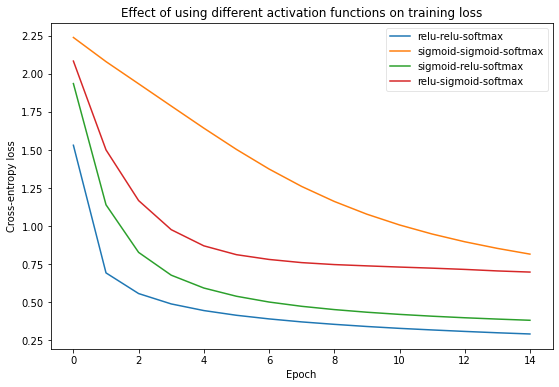

In [131]:
# Plot training loss for the different learning rates used
Utility.plot_results([activ_train[_][0] for _ in activ_fns_set],
    labels=[str(_) for _ in activ_fns_str],
    ylabel='Cross-entropy loss',
    title='Effect of using different activation functions on training loss')

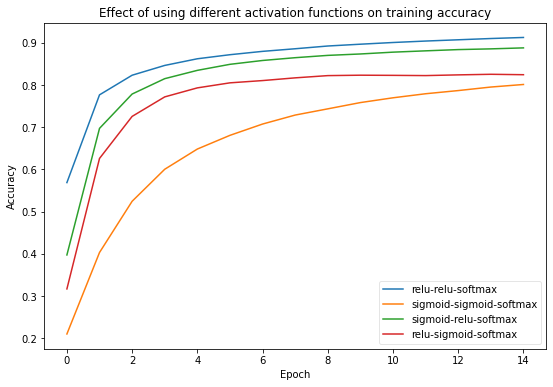

In [132]:
# Plot training loss for the different learning rates used
Utility.plot_results([activ_train[_][1] for _ in activ_fns_set],
    labels=[str(_) for _ in activ_fns_str],
    ylabel='Accuracy',
    title='Effect of using different activation functions on training accuracy')

In [133]:
# Validating: architecture vs. loss
print('Architecture, Validation loss, Validation accuracy')
for activ_fns, activ_str in zip(activ_fns_set, activ_fns_str):
    print('{}, {:5.3f}, {:.1f}%'.format(activ_str, activ_valid[activ_fns][0],
        activ_valid[activ_fns][1]*100))

Architecture, Validation loss, Validation accuracy
relu-relu-softmax, 0.317, 90.5%
sigmoid-sigmoid-softmax, 0.807, 79.6%
sigmoid-relu-softmax, 0.390, 88.5%
relu-sigmoid-softmax, 0.705, 81.6%


Based on the validation results, the model with ReLU activation functions in both of its hidden layers performed best when the learning rate, architecture, and number of epochs are held constant. In addition, it is most efficient in training time, as is expected. Thus, the model with ReLU in both of its hidden layers is selected.

Below, the chosen model's performance is reported by using the test data.

In [134]:
# Generate batches from test data, pass through model
test_gen = mnist_set.make_batches(batch, 'test')
loss, acc = activ_p[activ_fns_set[0]].pass_data(test_gen, train_mode=False) 
print('Cross-entropy loss: {:.3f}\nAccuracy: {:.1f}%'.format(loss, acc*100))

Cross-entropy loss: 0.304
Accuracy: 91.1%


# 3. Appendix

Simple tests to check basic functionality with hand calculations.

Hinge loss examples from class on 1/20/22

In [65]:
# 3-class classification example
z_ex1 = np.array([-3.7, 5, 7]).T
print('Target class is 3, hinge loss={:0.1f} \tif 2, {:0.1f} \tif 1, {:0.1f}'.format(
    Loss.hinge_loss(z_ex1, np.array([0, 0, 1]).T),
    Loss.hinge_loss(z_ex1, np.array([0, 1, 0]).T),
    Loss.hinge_loss(z_ex1, np.array([1, 0, 0]).T)))

Target class is 3, hinge loss=0.0 	if 2, 3.0 	if 1, 21.4


In [64]:
# 4-class classification example
z_ex2 = np.array([2.5, 2.0, 2.7, 1.7]).T
print('Target class is 2, hinge loss={:0.1f}'.format(
    Loss.hinge_loss(z_ex2, np.array([0, 1, 0, 0]).T)))

Target class is 2, hinge loss=3.9


Hinge loss example from class on 3/1/22

In [63]:
z_ex3 = np.array([1., 1.7, -0.5, 2.7]).T
print('Target class is 2, hinge loss={:0.1f}. Derivative wrt z={}'.format(
    Loss.hinge_loss(z_ex3, np.array([0, 1, 0, 0]).T),
    Loss.hinge_loss(z_ex3, np.array([0, 1, 0, 0]).T, derive=True)))

Target class is 2, hinge loss=2.3. Derivative wrt z=[ 1 -2  0  1]


Check softmax and cross-entropy methods

In [9]:
# Create output layer aggregation, activate through softmax
z_sample = np.array([[-1, 0, 3, 5], [-0.1, 1, 2, 3], 
    [1, 0.1, 0.2, 0.5]]).reshape(3, -1).T
yhat_sample = Activation.softmax(z_sample)
print('predictions:', yhat_sample)

# Make class 3 the target class
y_sample = np.array([[0, 0, 1, 0], [0, 0, 0, 1], 
    [1, 0, 0, 0]]).reshape(3, -1).T
print('cross-entropy loss:', Loss.cross_entropy(yhat_sample, y_sample), 
    '\nactual labels:', y_sample)

# Take cross-entropy loss gradient wrt outputs
grad_chain = Loss.cross_entropy(yhat_sample, y_sample, derive=1)

# Take loss gradient wrt logits by using chain rule (backup thru softmax)
deriv_softmax = Activation.softmax(z_sample, y_sample, derive=1)
grad_chain = grad_chain * deriv_softmax
print('gradient wrt logits:\n', grad_chain)

# Should be the same as shortcut when using both softmax and cross-entropy
print(np.isclose(grad_chain, yhat_sample - y_sample).all())

predictions: [[0.0021657  0.02909659 0.40610303]
 [0.00588697 0.08741099 0.16510917]
 [0.11824302 0.23760771 0.18247386]
 [0.87370431 0.64588471 0.24631394]]
cross-entropy loss: 1.157723745494379 
actual labels: [[0 0 1]
 [0 0 0]
 [1 0 0]
 [0 1 0]]
gradient wrt logits:
 [[ 0.0021657   0.02909659 -0.59389697]
 [ 0.00588697  0.08741099  0.16510917]
 [-0.88175698  0.23760771  0.18247386]
 [ 0.87370431 -0.35411529  0.24631394]]
True


Compute accuracy on two examples, one predicted correctly and one not:

In [23]:
yhat = np.array(((0.2, 0.5, 0.3), (0.7, 0.2, 0.1))).T
y = np.array(((0, 1, 0), (0, 1, 0))).T
Loss.accuracy(yhat, y)

0.5

Informal problem given at the end of class, 1/25/22:

In [82]:
p = Perceptron((4, 3, 2, 4), 
               (Activation.relu, Activation.sigmoid, Activation.softmax), 
               Loss.cross_entropy, init_with_normal=True)
p[1].w = np.array([[1.,0,0,0], [0,1,0,0], [0,0,1,0]])
p[2].w = np.array([[1.,0,0], [0,1,0]])
p[3].w = np.array([[1.,0], [0,1], [0,0], [0,0]])
p.zero_biases()

# Check forward path
p.forward(np.array([1, 0, 1, 0]).reshape(-1, 1), batch_size=1)
for i in range(1, len(p.dims)):
  print('Layer', i,'-> a =\n', p[i].a)

Layer 1 -> a =
 [[1.]
 [0.]
 [1.]]
Layer 2 -> a =
 [[0.73105858]
 [0.5       ]]
Layer 3 -> a =
 [[0.36278004]
 [0.28793597]
 [0.17464199]
 [0.17464199]]


In [85]:
# Check backpropagation
y = np.array([0., 1., 0., 0.]).reshape(-1, 1) # Dummy one-hot label
print('p[1].w before backprop\n', p[1].w)
p.backward(y, lr=0.5, batch_size=1)
print('p[1].w after backprop\n', p[1].w)
print('New output:', Activation.softmax(p[3].w @ p[2].a + p[3].b))

p[1].w before backprop
 [[1.04421637 0.         0.04421637 0.        ]
 [0.         1.         0.         0.        ]
 [0.03964693 0.         1.03964693 0.        ]]
p[1].w after backprop
 [[1.14514486 0.         0.14514486 0.        ]
 [0.         1.         0.         0.        ]
 [0.09621592 0.         1.09621592 0.        ]]
New output: [[0.05991671]
 [0.8446309 ]
 [0.04772619]
 [0.04772619]]


In [139]:
ph = Perceptron(dims_fixed, activ_fns_set[0], Loss.hinge_loss)
activ_train[activ_fns] = Utility.train_epochs(p, mnist_set, lr_fixed, 
epochs, batch, hinge_and_logits=True)

# After training a model, validate
valid_gen = mnist_set.make_batches(batch, 'valid')
activ_valid[activ_fns] = ph.pass_data(valid_gen, 0.001, batch, train_mode=False)

Epoch 	Train_loss 	Train_acc
0 	    4.003 	    0.714
1 	    2.770 	    0.845
2 	    2.524 	    0.869
3 	    2.399 	    0.884
4 	    2.273 	    0.895
5 	    2.219 	    0.901
6 	    2.150 	    0.907
7 	    2.095 	    0.912
8 	    2.050 	    0.915
9 	    2.000 	    0.920
10 	    1.966 	    0.922
11 	    1.928 	    0.924
12 	    1.885 	    0.927
13 	    1.852 	    0.929
14 	    1.820 	    0.931
Time elapsed (s): 22.6

